In [2]:
from src.graph_utils import *
from src import pge
from src import abe
from src import ace
import time
import os
import numpy as np
import matplotlib.pyplot as plt

In [40]:
from deap import base, creator, tools, algorithms

In [45]:
import random
from scipy.optimize import minimize


In [63]:
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit
from math import log2, ceil

In [39]:
from qiskit.circuit.library import Diagonal
from qiskit import QuantumCircuit, Aer, execute
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.primitives import Sampler
from qiskit.result import QuasiDistribution

In [38]:
from qiskit_algorithms.minimum_eigensolvers import QAOA, SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
from qiskit_algorithms.utils import algorithm_globals

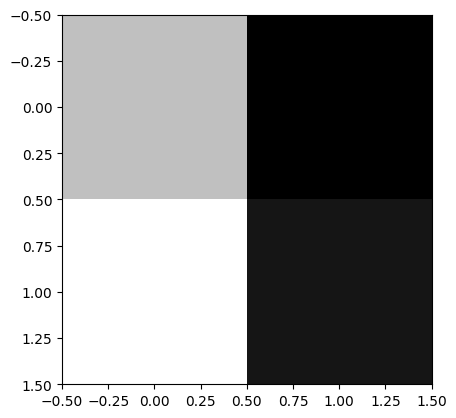

In [259]:
# height,width = 3,3
# image = np.array([
       # [0.92,  0.87, 0.39],
       # [0.93,  0.90, 0.45],
       # [0.94,  0.45, 0.40]
       # ])

height, width = 2, 2
image = np.array([
    [0.80, 0.35],
    [0.95, 0.40]
])

# 'hamming', 'bilinear', 'bessel', 'catrom', 'bicubic', 'lanczos', 'kaiser', 'gaussian', 
# 'none', 'spline16', 'quadric', 'blackman', 'hermite', 'hanning', 'mitchell', 'nearest', 
# 'sinc', 'spline36', 'antialiased'
plt.imshow(image, interpolation='nearest', cmap=plt.cm.gray)

In [260]:
def image_to_grid_graph(gray_img, sigma=0.5):
  # Convert image to grayscale
  # gray_img = np.dot(img, [0.2989, 0.5870, 0.1140])
  h, w = gray_img.shape
  # Initialize graph nodes and edges
  nodes = np.zeros((h*w, 1))
  edges = []
  nx_elist = []
  # Compute node potentials and edge weights
  min_weight = 1
  max_weight = 0
  for i in range(h*w):
    x, y = i//w, i%w
    nodes[i] = gray_img[x,y]
    if x > 0:
      j = (x-1)*w + y
      # weight = np.exp(-dist.euclidean([gray_img[x,y]], [gray_img[x-1,y]])**2 / (2*sigma**2))
      weight = 1-np.exp(-((gray_img[x,y] - gray_img[x-1,y])**2) / (2 * sigma**2))
      edges.append((i, j, weight))
      nx_elist.append(((x,y),(x-1,y),np.round(weight,2)))
      if min_weight>weight:min_weight=weight
      if max_weight<weight:max_weight=weight
    if y > 0:
      j = x*w + y-1
      # weight = np.exp(-dist.euclidean([gray_img[x,y]], [gray_img[x,y-1]])**2 / (2*sigma**2))
      weight = 1-np.exp(-((gray_img[x,y] - gray_img[x,y-1])**2) / (2 * sigma**2))
      # print('weight',weight)
      edges.append((i, j, weight))
      nx_elist.append(((x,y),(x,y-1),np.round(weight,2)))
      if min_weight>weight:min_weight=weight
      if max_weight<weight:max_weight=weight
  a=-1
  b=1
  if max_weight-min_weight:
    normalized_edges = [(node1,node2,-1*np.round(((b-a)*((edge_weight-min_weight)/(max_weight-min_weight)))+a,2)) for node1,node2,edge_weight in edges]
    normalized_nx_elist = [(node1,node2,-1*np.round(((b-a)*((edge_weight-min_weight)/(max_weight-min_weight)))+a,2)) for node1,node2,edge_weight in nx_elist]
  else:
    normalized_edges = [(node1,node2,-1*np.round(edge_weight,2)) for node1,node2,edge_weight in edges]
    normalized_nx_elist = [(node1,node2,-1*np.round(edge_weight,2)) for node1,node2,edge_weight in nx_elist]
  return nodes, edges, nx_elist, normalized_edges, normalized_nx_elist

pixel_values, elist, nx_elist, normalized_elist, normalized_nx_elist = image_to_grid_graph(image)



pixel_values, elist, nx_elist, normalized_elist, normalized_nx_elist

(array([[0.8 ],
        [0.35],
        [0.95],
        [0.4 ]]),
 [(1, 0, 0.33302318914152573),
  (2, 0, 0.04400251816690004),
  (3, 1, 0.00498752080731768),
  (3, 2, 0.4539255733602905)],
 [((0, 1), (0, 0), 0.33),
  ((1, 0), (0, 0), 0.04),
  ((1, 1), (0, 1), 0.0),
  ((1, 1), (1, 0), 0.45)],
 [(1, 0, -0.46), (2, 0, 0.83), (3, 1, 1.0), (3, 2, -1.0)],
 [((0, 1), (0, 0), -0.45),
  ((1, 0), (0, 0), 0.84),
  ((1, 1), (0, 1), 1.02),
  ((1, 1), (1, 0), -0.98)])

In [261]:
G = nx.grid_2d_graph(image.shape[0], image.shape[1])
G.add_weighted_edges_from(normalized_nx_elist)

In [262]:
G.nodes()

NodeView(((0, 0), (0, 1), (1, 0), (1, 1)))

Pos: {(0, 0): (0, 0), (0, 1): (1, 0), (1, 0): (0, -1), (1, 1): (1, -1)}
{((0, 0), (1, 0)): 0.84, ((0, 0), (0, 1)): -0.45, ((0, 1), (1, 1)): 1.02, ((1, 0), (1, 1)): -0.98}


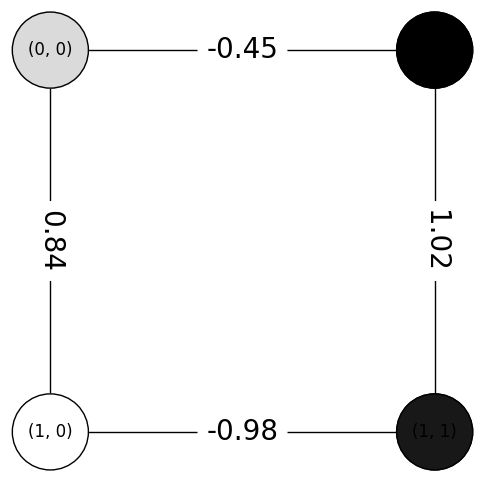

In [263]:
def draw(G):
  plt.figure(figsize=(6,6))
  default_axes = plt.axes(frameon=True)
  pos = {(x,y):(y,-x) for x,y in G.nodes()}
  print("Pos:",pos)
  nx.draw_networkx(G,
                  pos=pos,
                  node_color=1-pixel_values,
                  with_labels=True,
                  node_size=3000,
                  cmap=plt.cm.Greys,
                  alpha=1,
                  ax=default_axes)
  nodes = nx.draw_networkx_nodes(G, pos, node_color=1-pixel_values,
                  node_size=3000,
                  cmap=plt.cm.Greys)
  nodes.set_edgecolor('k')
  edge_labels = nx.get_edge_attributes(G, "weight")
  print(edge_labels)
  nx.draw_networkx_edge_labels(G,
                              pos=pos,
                              edge_labels=edge_labels,
                              font_size=20)
  plt.axis('off')
#   plt.savefig("2x2_graph.jpg", dpi=600, bbox_inches='tight', pad_inches=0)
draw(G)

#### Brute Force Solver

In [264]:
def bf_solver(G):
  n = G.number_of_nodes()
  w = nx.adjacency_matrix(G).todense()
  # print('weights matrix =',w)
  best_cost_brute = 100000
  for b in range(2**(n-1)):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
      for j in range(n):
        cost = cost + w[i,j]*x[i]*(1-x[j])
    if cost < best_cost_brute:
      best_cost_brute = cost
      xbest_brute = x
  return xbest_brute, best_cost_brute

#### Minimum Eigen Solver (Classical)

In [265]:
def me2_solver(G):
  n = G.number_of_nodes()
  w = -1 * nx.adjacency_matrix(G).todense()
  max_cut = Maxcut(w)
  qp = max_cut.to_quadratic_program()
  qubitOp, offset = qp.to_ising()
  exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
  result = exact.solve(qp)
  # return result.x, result.fval
  ee = NumPyMinimumEigensolver()
  result = ee.compute_minimum_eigenvalue(qubitOp)
  x = max_cut.sample_most_likely(result.eigenstate)
  return x, qp.objective.evaluate(x)

#### Qiskit QAOA Solver

In [266]:
def objective_value(x: np.ndarray, w: np.ndarray) -> float:
    """Compute the value of a cut.
    Args:
        x: Binary string as numpy array.
        w: Adjacency matrix.
    Returns:
        Value of the cut.
    """
    cost = 0
    for i in range(len(x)):
        for j in range(len(x)):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    return cost

def bitfield(n: int, L: int) -> list[int]:
    result = np.binary_repr(n, L)
    return [int(digit) for digit in result]  # [2:] to chop off the "0b" part

def sample_most_likely(state_vector) -> np.ndarray:
    """Compute the most likely binary string from state vector.
    Args:
        state_vector: State vector or quasi-distribution.

    Returns:
        Binary string as an array of ints.
    """
    if isinstance(state_vector, QuasiDistribution):
        values = list(state_vector.values())
    else:
        values = state_vector
    n = int(np.log2(len(values)))
    k = np.argmax(np.abs(values))
    x = bitfield(k, n)
    x.reverse()
    return np.asarray(x)

In [267]:
def qaoa_solver(G, reps=1):
  n = G.number_of_nodes()
  w = -1 * nx.adjacency_matrix(G).todense()
  max_cut = Maxcut(w)
  qp = max_cut.to_quadratic_program()
  # print(qp.prettyprint())
  qubitOp, offset = qp.to_ising()
  sampler = Sampler()
  algorithm_globals.random_seed = 123
  optimizer = COBYLA()
  qaoa = QAOA(sampler, optimizer, reps=reps)
  result = qaoa.compute_minimum_eigenvalue(qubitOp)
  x = sample_most_likely(result.eigenstate)
  return x, objective_value(x, w)

#### Parametric Gate Encoding (PGE)

In [268]:
def R(theta):
  if abs(theta) > 2*np.pi or abs(theta) < 0:
    theta = abs(theta) - (np.floor(abs(theta)/(2*np.pi))*(2*np.pi))
  return 0 if 0 <= theta < np.pi else 1

def cost_fn(params, hermitian_observable):
  global optimization_iteration_count
  optimization_iteration_count += 1
  N = int(np.log2(len(params)))
  circuit_psi = QuantumCircuit(N)
  for i in range(N):
    circuit_psi.h(i)
  diagonal_elements = [np.exp(1j * np.pi * R(param)) for param in params]
  diag_gate = Diagonal(diagonal_elements)
  circuit_psi.append(diag_gate, range(N))
  op_observable = SparsePauliOp.from_operator(hermitian_observable)
  cost = Estimator().run(circuit_psi, op_observable).result().values[0]
  print(f'@ Iteration {optimization_iteration_count} Cost :',cost)
  return cost

def decode(optimal_params):
  return [R(param) for param in optimal_params]

In [269]:
def new_nisq_ga_solver2(G, population_size=50, crossover_probability=0.7, mutation_probability=0.2, number_of_generations=50):
    n = G.number_of_nodes()
    w = nx.adjacency_matrix(G).todense()
    D_G = np.diag(list(dict(G.degree()).values()))
    A_G = w
    L_G = D_G - A_G
    n_padding = (2**int(np.ceil(np.log2(n))) - n)
    L_G = np.pad(L_G, [(0, n_padding), (0, n_padding)], mode='constant')
    H = L_G

    # Genetic Algorithm Setup
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, 0.5, 2*np.pi)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Evaluate function with padding
    def evaluate_with_padding(individual):
        padded_individual = individual + [0] * n_padding  # Append constant values for padding
        return cost_fn(padded_individual, H),

    toolbox.register("evaluate", evaluate_with_padding)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Run Genetic Algorithm
    population = toolbox.population(n=population_size)
    algorithms.eaSimple(population, toolbox, cxpb=crossover_probability, mutpb=mutation_probability, ngen=number_of_generations, verbose=False)

    # Extract the best solution
    best_ind = tools.selBest(population, 1)[0]
    optimal_params = best_ind + [0] * n_padding  # Append constant values for padding
    expectation_value = best_ind.fitness.values[0]

    # Decode and calculate cut value
    x = np.real(decode(optimal_params))
    x = x[:n]
    cut_value = objective_value(x, w)

    return x, expectation_value, cut_value


In [270]:
def new_nisq_algo_solver(G, optimizer_method = 'Genetic', initial_params_seed=123):
  global optimization_iteration_count
  optimization_iteration_count = 0
  if optimizer_method == 'Genetic':
    x, expectation_value, cut_value = new_nisq_ga_solver2(G,
                                                         population_size = 50,
                                                         crossover_probability = 0.7,
                                                         mutation_probability = 0.2,
                                                         number_of_generations = 50)
    success_flag = True
  else:
    n = G.number_of_nodes()
    w = nx.adjacency_matrix(G).todense()
    D_G = np.diag(list(dict(G.degree()).values()))
    A_G = w
    L_G = D_G - A_G
    n_padding = (2**int(np.ceil(np.log2(n)))-n)
    L_G = np.pad(L_G, [(0, n_padding), (0, n_padding) ], mode='constant')
    H = L_G
    # if initial_params is None:
    np.random.seed(seed=initial_params_seed)
    initial_params = np.random.uniform(low=0.5, high=2*np.pi , size=(n+n_padding))
    # optimizers_scipy = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP']
    # print(optimizer_method)
    options = {}
    result = minimize(
        fun=cost_fn,
        x0=initial_params,  # Initial guess for the parameters
        args=H,    # Additional arguments passed to evaluate_cost
        method=optimizer_method,
        options=options)
    optimal_params, expectation_value = result.x, result.fun
    x = np.real(decode(optimal_params))
    x = x[:n]
    cut_value = objective_value(x, w)
    success_flag = result.success
  return success_flag, x, expectation_value, cut_value

In [271]:
success_flag, x, expectation_value, cut_value = new_nisq_algo_solver(G, optimizer_method = 'Powell')
success_flag, x, expectation_value, cut_value

@ Iteration 1 Cost : 2.2149999999999994
@ Iteration 2 Cost : 2.2149999999999994
@ Iteration 3 Cost : 2.2149999999999994
@ Iteration 4 Cost : 1.8250000000000002
@ Iteration 5 Cost : 2.2149999999999994
@ Iteration 6 Cost : 1.8250000000000002
@ Iteration 7 Cost : 1.8250000000000002
@ Iteration 8 Cost : 1.8250000000000002
@ Iteration 9 Cost : 1.8250000000000002
@ Iteration 10 Cost : 2.2149999999999994
@ Iteration 11 Cost : 1.8250000000000002
@ Iteration 12 Cost : 1.8250000000000002
@ Iteration 13 Cost : 1.8250000000000002
@ Iteration 14 Cost : 0.3550000000000004
@ Iteration 15 Cost : 0.3550000000000004
@ Iteration 16 Cost : 0.3550000000000004
@ Iteration 17 Cost : 0.3550000000000004
@ Iteration 18 Cost : 0.3550000000000004
@ Iteration 19 Cost : 0.3550000000000004
@ Iteration 20 Cost : 0.3550000000000004
@ Iteration 21 Cost : 0.3550000000000004
@ Iteration 22 Cost : 0.3550000000000004
@ Iteration 23 Cost : 0.3550000000000004
@ Iteration 24 Cost : 0.3550000000000004
@ Iteration 25 Cost : 0.3

(True, array([0, 1, 0, 1]), 0.3550000000000004, -1.43)

In [272]:
x

array([0, 1, 0, 1])

In [273]:
def decode_binary_string(x, height, width):
  mask = np.zeros([height, width])
  for index,segment in enumerate(x):
    mask[index//width,index%width]=segment
  return mask

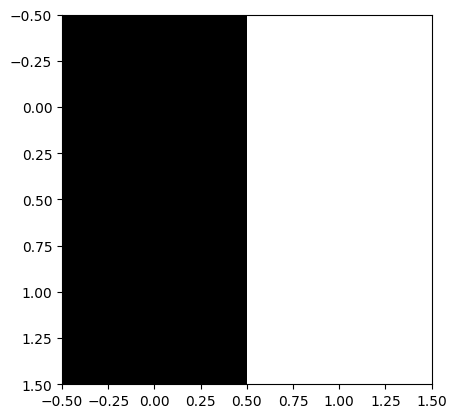

In [274]:
mask = decode_binary_string(x, height, width)
plt.imshow(mask, interpolation='nearest', cmap=plt.cm.gray)


#### Ancilla Basis Encoding (ABE)

In [275]:
def get_circuit(nq, n_layers):
  theta = ParameterVector('θ', length=nq*n_layers)
  qc = QuantumCircuit(nq)
  qc.h(range(nq))

  for layer_i in range(n_layers):
    # if layer_i%2:
    for qubit_i in range(nq - 1):
      qc.cx(qubit_i, (qubit_i + 1)%nq)
    for qubit_i in range(nq):
      qc.ry(theta[(nq*layer_i)+qubit_i], qubit_i)
  return qc

In [276]:
def get_projectors(probabilities, n_c):
  P = [0] * n_c
  P1 = [0] * n_c
  for k, v in probabilities.items():
    index = int(k[1:], 2)
    P[index] += v
    if k[0] == '1':
      P1[index] += v
  return P, P1

def objective_value(x: np.ndarray, w: np.ndarray) -> float:
    cost = 0
    for i in range(len(x)):
        for j in range(len(x)):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    return cost

def evaluate_cost(params, circuit, qubo_matrix):
  global ultimate_valid_probabilities
  global penultimate_valid_probabilities
  global optimization_iteration_count
  global n_shots
  optimization_iteration_count += 1
  # Create a copy of the circuit to avoid modifying the original
  working_circuit = circuit.copy()
  # Apply measurements
  working_circuit.measure_all()
  # Bind the parameters to the circuit
  bound_circuit = working_circuit.assign_parameters(params)
  # Run the circuit on a simulator
  simulator = Aer.get_backend('qasm_simulator')
  job = execute(bound_circuit, simulator, shots=n_shots)
  result = job.result()
  counts = result.get_counts()
  # Compute the probabilities of the states
  probabilities = {state: counts[state] / n_shots for state in counts}
  n_c = 2**(len(list(probabilities.keys())[0])-1)
  P, P1 = get_projectors(probabilities, n_c)
  if 0 in P:
    return 100000
  else:
    # Update the last valid probabilities
    penultimate_valid_probabilities = ultimate_valid_probabilities.copy()
    ultimate_valid_probabilities = probabilities.copy()
  cost = 0
  for i in range(len(qubo_matrix)):
    for j in range(len(qubo_matrix)):
      if i==j:
        cost += qubo_matrix[i][j] * P1[i]/P[i]
      else:
        cost += (qubo_matrix[i][j]*P1[i]*P1[j])/(P[i]*P[j])
  # print('min_cut_cost :', min_cut_cost)
  print(f'@ Iteration {optimization_iteration_count} Cost :',cost)
  return cost

def get_final_measurement_binary_string(circuit, params):
  working_circuit = circuit.copy()
  working_circuit.measure_all()
  bound_circuit = working_circuit.assign_parameters(params)
  simulator = Aer.get_backend('qasm_simulator')
  job = execute(bound_circuit, simulator, shots=1024)
  result = job.result()
  counts = result.get_counts()
  probabilities = {state: counts[state] / 1024 for state in counts}
  return probabilities

def decode_probabilities(probabilities):
  binary_solution = []
  n_r = len(list(probabilities.keys())[0])-1
  n_c = 2**(n_r)
  for i in range(n_c):
    if '0' + format(i, 'b').zfill(n_r) in probabilities and '1' + format(i, 'b').zfill(n_r) in probabilities:
      if probabilities['0' + format(i, 'b').zfill(n_r)] > probabilities['1' + format(i, 'b').zfill(n_r)]:
        binary_solution.append(0)
      else:
        binary_solution.append(1)
    elif '0' + format(i, 'b').zfill(n_r) in probabilities:
      binary_solution.append(0)
    elif '1' + format(i, 'b').zfill(n_r) in probabilities:
      binary_solution.append(1)
  return binary_solution

def decode_binary_string(x, height, width):
  mask = np.zeros([height, width])
  for index,segment in enumerate(x):
    mask[index//width,index%width]=segment
  return mask

In [277]:
def ancilla_basis_encoding(G, initial_params, n_layers = 1, optimizer_method = 'COBYLA'):
  w = nx.adjacency_matrix(G).todense()
  max_cut = Maxcut(-w)
  qp = max_cut.to_quadratic_program()
  linear = qp.objective.linear.coefficients.toarray(order=None, out=None)
  quadratic = qp.objective.quadratic.coefficients.toarray(order=None, out=None)
  linear = {int(idx):-round(value,2) for idx,value in enumerate(linear[0])}
  quadratic = {(int(iy),int(ix)):-quadratic[iy, ix] for iy, ix in np.ndindex(quadratic.shape) if iy<ix and abs(quadratic[iy, ix])!=0}
  nc = len(linear)
  nr = ceil(log2(nc))
  nq = nr + 1
  qc = get_circuit(nq, n_layers)
  global ultimate_valid_probabilities
  global penultimate_valid_probabilities
  global optimization_iteration_count
  ultimate_valid_probabilities = []
  penultimate_valid_probabilities = []
  optimization_iteration_count = 0
  options = {}
  optimization_result = minimize(
      fun=evaluate_cost,
      x0=initial_params,
      args=(qc, w),
      method=optimizer_method,
      bounds=tuple([(-np.pi, np.pi) for _ in range(len(initial_params))]),
      options=options)
  if not len(ultimate_valid_probabilities):
    return False, [0]*nc, 0, 0, [0]*initial_params
  binary_string_solution = decode_probabilities(ultimate_valid_probabilities)
  minimization_cost = optimization_result.fun
  optimal_params = optimization_result.x
  cut_cost = 0
  cut_cost = objective_value(np.array(list(map(int,binary_string_solution))), w)
  return optimization_result.success, binary_string_solution, minimization_cost, cut_cost, optimal_params


Executing QC with 2 layers and COBYLA optimizer for 2*2 image.
@ Iteration 1 Cost : 0.016941323345817723
@ Iteration 2 Cost : 0.03124272826440694
@ Iteration 3 Cost : -0.8126285556864044
@ Iteration 4 Cost : -0.01165426157031731
@ Iteration 5 Cost : -0.4921762114537446
@ Iteration 6 Cost : -0.14750711222428317
@ Iteration 7 Cost : 0.19657339393002693
@ Iteration 8 Cost : -0.6947510985484349
@ Iteration 9 Cost : -0.8653112777053455
@ Iteration 10 Cost : -0.812348562223842
@ Iteration 11 Cost : -0.4742979910714287
@ Iteration 12 Cost : -0.9000000000000001
@ Iteration 13 Cost : -0.7135057862491492
@ Iteration 14 Cost : -0.8639627263557328
@ Iteration 15 Cost : -0.4240146486396486
@ Iteration 16 Cost : -0.8460011259148058
@ Iteration 17 Cost : -0.9
@ Iteration 18 Cost : -0.8660692427965153
@ Iteration 19 Cost : -0.8964000000000001
@ Iteration 20 Cost : -0.8814462130816547
@ Iteration 21 Cost : -0.89375
@ Iteration 22 Cost : -0.896414342629482
@ Iteration 23 Cost : -0.8644592556849026
@ Ite

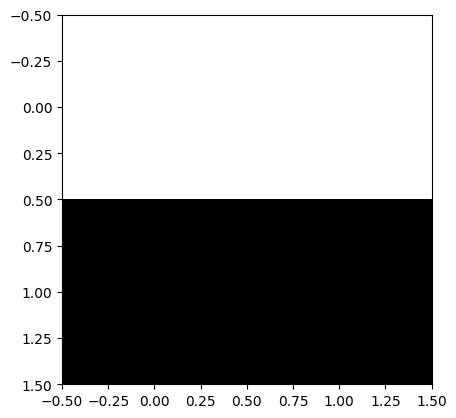

In [294]:
n_shots = 1024

ultimate_valid_probabilities = []
penultimate_valid_probabilities = []

optimization_iteration_count = 0


base_path = './'

initial_params_seed = 123
# scipy_optimizer_methods = ["COBYLA", "Powell", "CG", "BFGS", "L-BFGS-B", "SLSQP"]
scipy_optimizer_method = "COBYLA"
n_layers = 2


nc = len(G.nodes())
nr = ceil(log2(nc))
nq = nr + 1
initial_params = np.random.uniform(low=-np.pi, high=np.pi, size=nq*n_layers)
print(f"Executing QC with {n_layers} layers and {scipy_optimizer_method} optimizer for {height}*{height} image.")
# try:
start_time = time.time()
success_flag, minimal_encoding_solution, minimal_encoding_value, minimal_encoding_cut_value, optimal_params = ancilla_basis_encoding(G,
                                                                                                              initial_params,
                                                                                                              n_layers = n_layers,
                                                                                                              optimizer_method = scipy_optimizer_method)
success_flag, minimal_encoding_solution, minimal_encoding_value, minimal_encoding_cut_value, optimal_params

minimal_encoding_mask = decode_binary_string(minimal_encoding_solution, height, width)
plt.imshow(minimal_encoding_mask, interpolation='nearest', cmap=plt.cm.gray)

#### Adaptive Cost Encoding (ACE)

In [303]:
def evaluate_mincut_cost(params, circuit, w):
  global optimization_iteration_count
  global n_shots
  global best_cost
  global best_cost_binary_solution
  optimization_iteration_count += 1
  working_circuit = circuit.copy()

  # Apply measurements
  working_circuit.measure_all()

  # Bind the parameters to the circuit
  bound_circuit = working_circuit.assign_parameters(params)

  # Run the circuit on a simulator
  simulator = Aer.get_backend('qasm_simulator')
  job = execute(bound_circuit, simulator, shots=n_shots)
  result = job.result()
  counts = result.get_counts()

  probabilities = {state: counts[state] / n_shots for state in counts}
  n_c = 2**(len(list(probabilities.keys())[0])-1)
  P, P1 = get_projectors(probabilities, n_c)

  if 0 in P:
    return 100000

  binary_solution = decode_probabilities(probabilities)
  cost = objective_value(binary_solution, w)
  if cost < best_cost:
    best_cost = cost
    best_cost_binary_solution = binary_solution

  print(f'@ Iteration {optimization_iteration_count} Cost :',np.round(cost,2))
  print(f'Best Cost Found:',np.round(best_cost,2),"\n")
  return cost

In [304]:
def adaptive_cost_encoding(G, initial_params, n_layers = 1, max_iter = 2000, optimizer_method = 'COBYLA'):
  w = nx.adjacency_matrix(G).todense()
  max_cut = Maxcut(-w)
  qp = max_cut.to_quadratic_program()
  linear = qp.objective.linear.coefficients.toarray(order=None, out=None)
  quadratic = qp.objective.quadratic.coefficients.toarray(order=None, out=None)
  linear = {int(idx):-round(value,2) for idx,value in enumerate(linear[0])}
  quadratic = {(int(iy),int(ix)):-quadratic[iy, ix] for iy, ix in np.ndindex(quadratic.shape) if iy<ix and abs(quadratic[iy, ix])!=0}
  nc = len(linear)
  nr = ceil(log2(nc))
  nq = nr + 1
  qc = get_circuit(nq, n_layers)
  global optimization_iteration_count
  global best_cost
  global best_cost_binary_solution

  optimization_iteration_count = 0
  options = {}
  optimization_result = minimize(
      fun=evaluate_mincut_cost,
      x0=initial_params,
      args=(qc, w),
      method=optimizer_method,
      options=options)

  minimization_cost = optimization_result.fun
  return optimization_result.success, best_cost_binary_solution, minimization_cost, best_cost



Executing QC with 2 layers and Powell optimizer for 2*2 image.
@ Iteration 1 Cost : -1.43
Best Cost Found: -1.43 

@ Iteration 2 Cost : -1.43
Best Cost Found: -1.43 

@ Iteration 3 Cost : 0.57
Best Cost Found: -1.43 

@ Iteration 4 Cost : -1.43
Best Cost Found: -1.43 

@ Iteration 5 Cost : -1.43
Best Cost Found: -1.43 

@ Iteration 6 Cost : -1.43
Best Cost Found: -1.43 

@ Iteration 7 Cost : -1.43
Best Cost Found: -1.43 

@ Iteration 8 Cost : -1.43
Best Cost Found: -1.43 

@ Iteration 9 Cost : -1.43
Best Cost Found: -1.43 

@ Iteration 10 Cost : -1.43
Best Cost Found: -1.43 

@ Iteration 11 Cost : -1.43
Best Cost Found: -1.43 

@ Iteration 12 Cost : -1.43
Best Cost Found: -1.43 

@ Iteration 13 Cost : -1.43
Best Cost Found: -1.43 

@ Iteration 14 Cost : -1.43
Best Cost Found: -1.43 

@ Iteration 15 Cost : -1.43
Best Cost Found: -1.43 

@ Iteration 16 Cost : -1.43
Best Cost Found: -1.43 

@ Iteration 17 Cost : -1.43
Best Cost Found: -1.43 

@ Iteration 18 Cost : -1.43
Best Cost Found: -

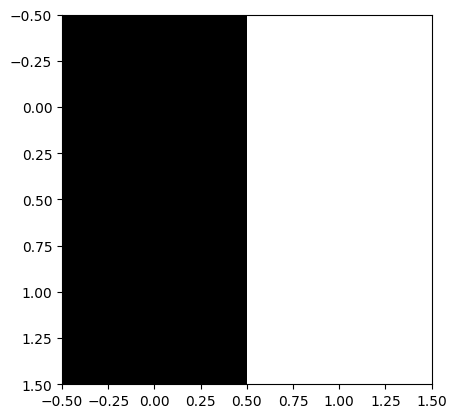

In [316]:
n_shots = 1024

best_cost = 1000000
best_cost_binary_solution = [0] * (height*width)

optimization_iteration_count = 0


base_path = './'

initial_params_seed = 123
# scipy_optimizer_methods = ["COBYLA", "Powell", "CG", "BFGS", "L-BFGS-B", "SLSQP"]
scipy_optimizer_method = "Powell"
n_layers = 2


nc = len(G.nodes())
nr = ceil(log2(nc))
nq = nr + 1
initial_params = np.random.uniform(low=-np.pi, high=np.pi, size=nq*n_layers)

print(f"Executing QC with {n_layers} layers and {scipy_optimizer_method} optimizer for {height}*{height} image.")
# try:
start_time = time.time()
success_flag, adaptive_cost_solution, adaptive_cost_value, adaptive_cost_cut_value = adaptive_cost_encoding(G,
                                                                                                            initial_params,
                                                                                                            n_layers = n_layers,
                                                                                                            optimizer_method = scipy_optimizer_method)
# success_flag, adaptive_cost_solution, adaptive_cost_value, adaptive_cost_cut_value, adaptive_cost_optimal_params

adaptive_cost_mask = decode_binary_string(adaptive_cost_solution, height, width)
plt.imshow(adaptive_cost_mask, interpolation='nearest', cmap=plt.cm.gray)

In [317]:
from scipy.optimize import differential_evolution

In [318]:
def adaptive_cost_encoding_de(G, initial_params, n_layers = 1, max_iter = 200):
  w = nx.adjacency_matrix(G).todense()
  max_cut = Maxcut(-w)
  qp = max_cut.to_quadratic_program()
  linear = qp.objective.linear.coefficients.toarray(order=None, out=None)
  quadratic = qp.objective.quadratic.coefficients.toarray(order=None, out=None)
  linear = {int(idx):-round(value,2) for idx,value in enumerate(linear[0])}
  quadratic = {(int(iy),int(ix)):-quadratic[iy, ix] for iy, ix in np.ndindex(quadratic.shape) if iy<ix and abs(quadratic[iy, ix])!=0}
  nc = len(linear)
  nr = ceil(log2(nc))
  nq = nr + 1
  qc = get_circuit(nq, n_layers)
  global best_cost
  global best_cost_binary_solution
  optimization_iteration_count = 0
  
  optimization_result = differential_evolution(
      func=evaluate_mincut_cost,
      args = (qc, w),
      bounds=tuple([(-np.pi, np.pi) for _ in range(len(initial_params))]),
      )
  minimization_cost = optimization_result.fun
  return optimization_result.success, best_cost_binary_solution, minimization_cost, best_cost


Executing QC with 1 layers and Powell optimizer for 2*2 image.
@ Iteration 1 Cost : 0.39
Best Cost Found: 0.39 

@ Iteration 3 Cost : 0.0
Best Cost Found: 0.0 

@ Iteration 4 Cost : 0.0
Best Cost Found: 0.0 

@ Iteration 5 Cost : 0.0
Best Cost Found: 0.0 

@ Iteration 6 Cost : 0.0
Best Cost Found: 0.0 

@ Iteration 7 Cost : 0.0
Best Cost Found: 0.0 

@ Iteration 8 Cost : 0.0
Best Cost Found: 0.0 

@ Iteration 9 Cost : 0.0
Best Cost Found: 0.0 

@ Iteration 10 Cost : 0.0
Best Cost Found: 0.0 

@ Iteration 11 Cost : 0.0
Best Cost Found: 0.0 

@ Iteration 12 Cost : 0.04
Best Cost Found: 0.0 

@ Iteration 13 Cost : 0.0
Best Cost Found: 0.0 

@ Iteration 16 Cost : 0.0
Best Cost Found: 0.0 

@ Iteration 17 Cost : 0.0
Best Cost Found: 0.0 

@ Iteration 18 Cost : 0.0
Best Cost Found: 0.0 

@ Iteration 19 Cost : 0.0
Best Cost Found: 0.0 

@ Iteration 20 Cost : 0.0
Best Cost Found: 0.0 

@ Iteration 21 Cost : 0.0
Best Cost Found: 0.0 

@ Iteration 22 Cost : 0.0
Best Cost Found: 0.0 

@ Iteration

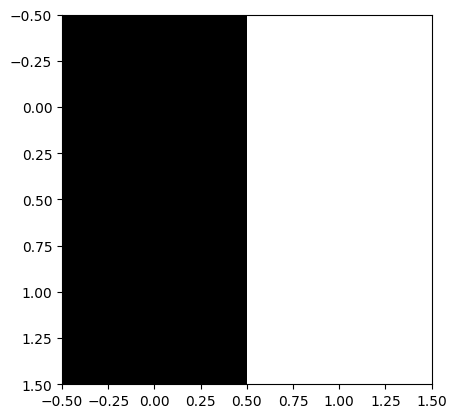

In [319]:
n_shots = 1024

best_cost = 1000000
best_cost_binary_solution = [0] * (height*width)

optimization_iteration_count = 0


base_path = './'

initial_params_seed = 123
# scipy_optimizer_methods = ["COBYLA", "Powell", "CG", "BFGS", "L-BFGS-B", "SLSQP"]
n_layers = 1


nc = len(G.nodes())
nr = ceil(log2(nc))
nq = nr + 1
initial_params = np.random.uniform(low=-np.pi, high=np.pi, size=nq*n_layers)

print(f"Executing QC with {n_layers} layers and {scipy_optimizer_method} optimizer for {height}*{height} image.")
# try:
start_time = time.time()
success_flag, adaptive_cost_de_solution, adaptive_cost_de_value, adaptive_cost_de_cut_value = adaptive_cost_encoding_de(G,
                                                                                                            initial_params,
                                                                                                            n_layers = n_layers)

adaptive_cost_de_mask = decode_binary_string(adaptive_cost_de_solution, height, width)
plt.imshow(adaptive_cost_mask, interpolation='nearest', cmap=plt.cm.gray)